## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy
from optimization.functions import read_each_loader, convert_sample_2_df, trajectory_estimation

from models.policy_model import RobotPolicy

In [2]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory)

Evaluating Device:  cpu
Current Time:  Jan_31_2024-11_37_46


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load demonstrations dataset
evaluation_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  10
Full Demo Dataset Size:  406


# Functions

In [6]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

# Test

In [7]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Jan_31_2024-09_57_07"

In [8]:
params_name = "policy_network_epoch_100_loss_3_83506.pt"

In [9]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [10]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [11]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [12]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

In [13]:
sample_index = 25

In [14]:
evaluation_sample = evaluation_data[sample_index]

In [15]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [16]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))

In [17]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [18]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=evaluation_data.state_norms)

In [19]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=evaluation_data.action_norms)[0]

In [20]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=evaluation_data.action_norms)[0]

# Run Through All Samples in a Trajectory for Every Trajectory

In [21]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [22]:
for idx, sample_data in enumerate(evaluation_data):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=sample_data)
    
    # add a batch dimension by unsqueezing
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))
    
    # multivariate Gaussian negative log-likelihood loss function
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=evaluation_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                                   norm_range_list=evaluation_data.action_norms)[0]
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=evaluation_data.action_norms)[0]
    
    # store every important detail in the dataframe
    sample_df = convert_sample_2_df(input_state=input_state,
                                    real_state_input=real_state_input,
                                    output_action=output_action,
                                    real_action_output=real_action_output,
                                    action_log_prob=action_log_prob,
                                    action_pred=action_pred,
                                    action_std=action_std,
                                    real_action_pred=real_action_pred,
                                    trajectory_index=int(trajectory_index),
                                    state_number=int(state_number),
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        df = pd.concat([df, sample_df],
                       ignore_index=True)
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

In [23]:
trajectory_dataframes[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,...,action_pred_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss
0,0.557423889637,0.845148146152,0.152274101973,0.413727521896,1.114847779274,1.690296292305,0.304548203945,0.827455043793,-0.206786960363,-0.263957113028,...,0.364831477404,0.358997941017,0.358992815018,0.359004110098,-0.451102614403,-0.508148193359,0.729662895203,41,0,3.834225177765
1,0.467088162899,0.782375752926,0.106058746576,0.421456843615,0.934176325798,1.564751505852,0.212117493153,0.842913687229,-0.274574905634,-0.117239050567,...,0.371330320835,0.358997941017,0.358992815018,0.359004110098,-0.539388179779,-0.311354875565,0.742660522461,41,1,3.834460735321
2,0.289939045906,0.641510844231,0.177682518959,0.420233011246,0.579878091812,1.283021688461,0.355365037918,0.840466022491,-0.280997991562,0.046184424311,...,0.347531706095,0.358997941017,0.358992815018,0.359004110098,-0.597241640091,0.129903554916,0.695063352585,41,2,3.834004878998
3,0.189123824239,0.513984918594,0.317737460136,0.396792560816,0.378247648478,1.027969837189,0.635474920273,0.793585121632,-0.258398354053,0.182242289186,...,0.306269705296,0.358997941017,0.358992815018,0.359004110098,-0.546186447144,0.413757801056,0.612539291382,41,3,3.834020853043
4,0.203070998192,0.420127540827,0.439699143171,0.341573148966,0.406141996384,0.840255081654,0.879398286343,0.683146297932,-0.233832702041,0.278123915195,...,0.252358675003,0.358997941017,0.358992815018,0.359004110098,-0.456297159195,0.578459262848,0.504717350006,41,4,3.833854675293
5,0.230293363333,0.328111082315,0.520886838436,0.247494399548,0.460586726665,0.656222164631,1.041773676872,0.494988799095,-0.229463696480,0.273556470871,...,0.163362890482,0.358997941017,0.358992815018,0.359004110098,-0.422128677368,0.641937732697,0.326725721359,41,5,3.834441184998
6,0.243417412043,0.241953834891,0.547509610653,0.115627251565,0.486834824085,0.483907669783,1.095019221306,0.231254503131,-0.219121053815,0.333380490541,...,0.077519148588,0.358997941017,0.358992815018,0.359004110098,-0.410241365433,0.630520105362,0.155038356781,41,6,3.834457635880
7,0.313775777817,0.101611763239,0.630524098873,0.068153508008,0.627551555634,0.203223526478,1.261048197746,0.136307016015,-0.179725974798,0.333937913179,...,-0.027880785987,0.358997941017,0.358992815018,0.359004110098,-0.371265053749,0.711989641190,-0.055761575699,41,7,3.833971500397
8,0.358732581139,0.046200826764,0.652878761292,0.070783331990,0.717465162277,0.092401653528,1.305757522583,0.141566663980,-0.167760327458,0.361364185810,...,-0.051049362868,0.358997941017,0.358992815018,0.359004110098,-0.356233358383,0.729212522507,-0.102098703384,41,8,3.834183692932


In [24]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

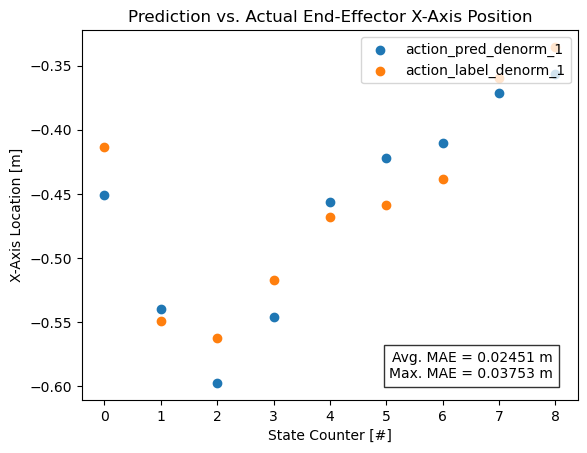

In [25]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

In [26]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

In [27]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

trajectory_estimation(configs=configs,
                      data_loader=evaluation_data,
                      policy_network=policy_network,
                      trajectory_length=constants.TRAJECTORY_SIZE)


state_number :  0
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.4112674  -0.30779302  0.60889959]
current_state_denorm_estimation :  [0.81735593 1.35957921 0.06278246 0.77739966]
next_state_denorm_label :  [0.86942815 1.32989333 0.         0.77739959]

state_number :  1
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.58261347 -0.22063708  0.68234015]
current_state_denorm_estimation :  [0.82772833 1.27771389 0.10765906 0.81917554]
next_state_denorm_label :  [1.01522468 1.32470659 0.20578908 0.85084015]

state_number :  2
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  [-0.69073534  0.03005457  0.68693328]
current_state_denorm_estimation :  [0.69193149 1.26118779 0.20802534 0.83032709]
next_state_denorm_label :  [1.09921705 1.17841894 0.44534546 0.85543328]

state_number :  3
initial_state_location :  [-0.4112674  -0.30779302  0.60889959]
action_denorm_label :  

In [28]:
trajectory_dataframes[0][["state_label_denorm_1", "state_label_denorm_2", "state_label_denorm_3", "state_label_denorm_4",
                          "action_label_denorm_1", "action_label_denorm_2", "action_label_denorm_3",
                          "state_number", "trajectory_index"]]

,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,state_number,trajectory_index
0,0.817355930805,1.359579205513,0.062782458961,0.777399659157,-0.411267399788,-0.307793021202,0.608899593353,0,0
1,0.749341726303,1.345113158226,0.091292686760,0.850840091705,-0.582613468170,-0.220637083054,0.682340145111,1,0
2,0.610901355743,1.313505291939,0.330848038197,0.855433344841,-0.690735340118,0.030054569244,0.686933279037,2,0
3,0.403398275375,1.152266025543,0.579016268253,0.867492616177,-0.707678318024,0.341165065765,0.698992729187,3,0
4,0.347195714712,0.972296237946,0.866340041161,0.871500253677,-0.569955348969,0.637730121613,0.703000307083,4,0
5,0.560571551323,0.825414359570,1.109057188034,0.750032007694,-0.385704755783,0.734245300293,0.581532001495,5,0
6,0.671198368073,0.674180507660,1.194474816322,0.449345678091,-0.289792299271,0.727063417435,0.280845642090,6,0
7,0.691959977150,0.375420719385,1.219006538391,0.211279332638,-0.303528666496,0.762950897217,0.042779445648,7,0
8,0.758535563946,0.135939523578,1.321065306664,0.051889520139,-0.315587043762,0.773996353149,-0.116610527039,8,0


In [29]:
0.703000307083 + 0.1685

0.871500307083

In [30]:
trajectory_dataframes[0]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,...,action_pred_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss
0,0.408677965403,0.679789602757,0.031391229481,0.388699829578,0.817355930805,1.359579205513,0.062782458961,0.777399659157,-0.205633714795,-0.153896495700,...,0.325337737799,0.358997941017,0.358992815018,0.359004110098,-0.394802451134,-0.209945440292,0.650675535202,0,0,3.834517240524
1,0.374670863152,0.672556579113,0.045646343380,0.425420045853,0.749341726303,1.345113158226,0.091292686760,0.850840091705,-0.291306763887,-0.110318548977,...,0.348973125219,0.358997941017,0.358992815018,0.359004110098,-0.435006141663,-0.101587533951,0.697946310043,0,1,3.836017847061
2,0.305450677872,0.656752645969,0.165424019098,0.427716672421,0.610901355743,1.313505291939,0.330848038197,0.855433344841,-0.345367670059,0.015027273446,...,0.353827327490,0.358997941017,0.358992815018,0.359004110098,-0.598398208618,0.100279092789,0.707654714584,0,2,3.834657192230
3,0.201699137688,0.576133012772,0.289508134127,0.433746308088,0.403398275375,1.152266025543,0.579016268253,0.867492616177,-0.353839129210,0.170582592487,...,0.338559538126,0.358997941017,0.358992815018,0.359004110098,-0.631837248802,0.346616506577,0.677119016647,0,3,3.834192276001
4,0.173597857356,0.486148118973,0.433170020580,0.435750126839,0.347195714712,0.972296237946,0.866340041161,0.871500253677,-0.284977644682,0.318865031004,...,0.308819472790,0.358997941017,0.358992815018,0.359004110098,-0.604168653488,0.588598728180,0.617639064789,0,4,3.834473371506
5,0.280285775661,0.412707179785,0.554528594017,0.375016003847,0.560571551323,0.825414359570,1.109057188034,0.750032007694,-0.192852392793,0.367122590542,...,0.255773276091,0.358997941017,0.358992815018,0.359004110098,-0.427083492279,0.714432239532,0.511546611786,0,5,3.834237575531
6,0.335599184036,0.337090253830,0.597237408161,0.224672839046,0.671198368073,0.674180507660,1.194474816322,0.449345678091,-0.144896149635,0.363531738520,...,0.179736971855,0.358997941017,0.358992815018,0.359004110098,-0.314331293106,0.729698419571,0.359473943710,0,6,3.834224700928
7,0.345979988575,0.187710359693,0.609503269196,0.105639666319,0.691959977150,0.375420719385,1.219006538391,0.211279332638,-0.151764318347,0.381475418806,...,0.047793138772,0.358997941017,0.358992815018,0.359004110098,-0.293259263039,0.706588268280,0.095586299896,0,7,3.834180831909
8,0.379267781973,0.067969761789,0.660532653332,0.025944760069,0.758535563946,0.135939523578,1.321065306664,0.051889520139,-0.157793551683,0.386998146772,...,-0.038700282574,0.358997941017,0.358992815018,0.359004110098,-0.321913838387,0.724543571472,-0.077400565147,0,8,3.834055900574


In [31]:
trajectory_dataframes[0].columns

Index(['state_label_norm_1', 'state_label_norm_2', 'state_label_norm_3',
       'state_label_norm_4', 'state_label_denorm_1', 'state_label_denorm_2',
       'state_label_denorm_3', 'state_label_denorm_4', 'action_label_norm_1',
       'action_label_norm_2', 'action_label_norm_3', 'action_label_denorm_1',
       'action_label_denorm_2', 'action_label_denorm_3',
       'action_pred_logprob_1', 'action_pred_logprob_2',
       'action_pred_logprob_3', 'action_pred_1', 'action_pred_2',
       'action_pred_3', 'action_pred_std_1', 'action_pred_std_2',
       'action_pred_std_3', 'action_pred_denorm_1', 'action_pred_denorm_2',
       'action_pred_denorm_3', 'trajectory_index', 'state_number',
       'gnll_loss'],
      dtype='object')

In [32]:
np.log(2 * np.pi)

1.8378770664093453

In [33]:
0.80889959 - 0.777477681637

0.03142190836299996

In [34]:
0.2-0.03142190836299996

0.16857809163700005